#Face OB Detection 
## From Scratch by Muhammad Hanan Asghar

In [ ]:
!pip uninstall opencv-python
!pip install opencv-python

In [2]:
! pip install --upgrade albumentations

  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import os
import cv2
import time
import uuid
import json
import numpy as np
import tensorflow as tf
import albumentations as alb
from matplotlib import pyplot as plt

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
!cp "/content/drive/MyDrive/OB Detection.zip" "/content/"

In [ ]:
!unzip *.zip && rm -rf *.zip

In [10]:
%cd "/content/OB Detection"

/content/OB Detection


In [11]:
!ls

 Augmentation.ipynb		       data
'Collecting and Labeling Data.ipynb'  'Splitting and Overviewing Dataset.ipynb'


# Augmenting Data

In [12]:
AUGMENTED_FOLDER = "aug_data"
if not os.path.exists(AUGMENTED_FOLDER):
    os.mkdir(AUGMENTED_FOLDER)
    
for fd in ['train', 'test', 'val']:
    folder_path = os.path.join(AUGMENTED_FOLDER, fd)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    
    for fd_pt in ["images", "labels"]:
        internal_path = os.path.join(folder_path, fd_pt)
        if not os.path.exists(internal_path):
            os.mkdir(internal_path)

In [13]:
augmentor = alb.Compose(
[alb.RandomCrop(width=450, height=450),
alb.HorizontalFlip(p=0.5),
alb.RandomBrightnessContrast(p=0.2),
alb.RandomGamma(p=0.2),
alb.RGBShift(p=0.2),
alb.VerticalFlip(p=0.5)],
bbox_params = alb.BboxParams(
format = "albumentations",
label_fields=['class_labels']
))

In [14]:
for split_folder in ['train', 'test', 'val']:
    split_folder_path = os.path.join('data', split_folder)
    for image_name in os.listdir(os.path.join(split_folder_path, "images")):
        image_path = os.path.join(split_folder_path, "images", image_name)
        img = cv2.imread(image_path)
        
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(split_folder_path, "labels", image_name.split(".")[0]+".json")
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]

            coords = list(np.divide(coords, [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]))

        
        try:
            for idx in range(120):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                
                save_image_path = os.path.join("aug_data",split_folder, "images", image_name.split(".")[0]+"_"+str(idx)+".jpg")
                save_label_path = os.path.join("aug_data",split_folder, "labels", image_name.split(".")[0]+"_"+str(idx)+".json")
                
                annotation = {}
                annotation['image'] = image_name
                cv2.imwrite(save_image_path, augmented['image'])
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                    
                with open(save_label_path, 'w') as f:
                    json.dump(annotation, f)
                
        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.3263888888888889, 0.7448302469135801, 0.0023148148148148147, 0.3636574074074074, 'face'].
x_max is less than or equal to x_min for bbox [0.2789351851851852, 0.8142746913580247, 0.0011574074074074073, 0.3914351851851851, 'face'].
x_max is less than or equal to x_min for bbox [0.2685185185185185, 0.7525462962962962, 0.0023148148148148147, 0.38680555555555546, 'face'].
x_max is less than or equal to x_min for bbox [0.2650462962962963, 0.8266203703703704, 0.0011574074074074073, 0.41612654320987646, 'face'].
x_max is less than or equal to x_min for bbox [0.28587962962962965, 0.8405092592592591, 0.0023148148148148147, 0.32353395061728396, 'face'].


#Loading Data in TF Datasets

## Images in TF Datasets

In [15]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [16]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [17]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [18]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

## Labels in TF Datasets

In [53]:
def load_labels(label_path):
  with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
    label = json.load(f)
  
  return [label['class']], label['bbox']

In [55]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [56]:
test_labels = tf.data.Dataset.list_files("aug_data/test/labels/*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [57]:
val_labels = tf.data.Dataset.list_files("aug_data/val/labels/*.json", shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [58]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6840, 6840, 1440, 1440, 1560, 1560)

# TF DATASETS

In [61]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(8000)
train = train.batch(8)
train = train.prefetch(4)

In [62]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [63]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2500)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

In [65]:
data_samples = train.as_numpy_iterator()

In [71]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


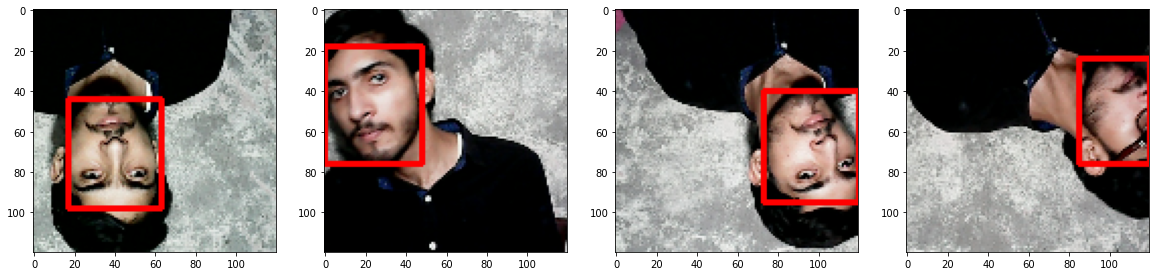

In [72]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Model

In [69]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [70]:
vgg = VGG16(include_top=False)
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [80]:
def builder():
  input = Input(shape=(120, 120, 3))
  
  vgg = VGG16(include_top=False)(input)

  # Classification
  class_layer = GlobalMaxPooling2D()(vgg)
  class_dense = Dense(units=2048, activation="relu")(class_layer)
  classification = Dense(units=1, activation="sigmoid")(class_dense)

  # Regression or Boudning Box Model
  regress_layer = GlobalMaxPooling2D()(vgg)
  regress_dense = Dense(units=2048, activation="relu")(regress_layer)
  regression = Dense(units=4, activation="sigmoid")(regress_dense)

  model = Model(inputs=[input], outputs=[classification, regression])
  return model

In [81]:
ob_model = builder()

In [82]:
ob_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [83]:
X, y = train.as_numpy_iterator().next()

In [84]:
X.shape

(8, 120, 120, 3)

In [85]:
classes, coords = ob_model.predict(X)

In [86]:
classes, coords

(array([[0.39922515],
        [0.3163744 ],
        [0.34062514],
        [0.30902505],
        [0.4339521 ],
        [0.37854457],
        [0.42391184],
        [0.25590163]], dtype=float32),
 array([[0.3483588 , 0.28893146, 0.49198216, 0.41018555],
        [0.43448296, 0.38203683, 0.5914955 , 0.3840195 ],
        [0.49030817, 0.25517514, 0.46124858, 0.449921  ],
        [0.42616493, 0.28666368, 0.45163295, 0.3825532 ],
        [0.3888818 , 0.23341645, 0.50249237, 0.3568748 ],
        [0.45425126, 0.2792454 , 0.4482442 , 0.4495523 ],
        [0.39810562, 0.33090216, 0.4999012 , 0.40991384],
        [0.33012608, 0.26773015, 0.56156784, 0.27787304]], dtype=float32))

# Loss and Optimizer

In [87]:
batches_per_epoch = 700
lr_decay = (1. / .75 - 1)/batches_per_epoch

In [88]:
lr_decay

0.0004761904761904761

In [90]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [111]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [112]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [113]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5352798>

In [114]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0434746>

In [115]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5352798>

# Training

In [153]:
class Trainer(Model):
  def __init__(self, tracker, **kwargs):
    super().__init__(**kwargs)
    self.model = tracker


  def compile(self, optimizer, classification_loss, regression_loss, **kwargs):
    super().compile(**kwargs)
    self.closs = classification_loss
    self.lloss = regression_loss
    self.opt = optimizer

  def train_step(self, batch, **kwargs):

    input, output = batch

    with tf.GradientTape() as tape:
      classes, coords = self.model(input, training=True)

      batch_classification_loss = self.closs(output[0], classes)
      batch_regression_loss = self.lloss(tf.cast(output[1], tf.float32), coords)

      total_loss = batch_regression_loss+0.5*batch_classification_loss

      gradients = tape.gradient(total_loss, self.model.trainable_variables)

    self.opt.apply_gradients(zip(gradients, self.model.trainable_variables))
    
    out_string = {'total_loss':total_loss,
                  "classification_loss":batch_classification_loss,
                  "Regression_loss":batch_regression_loss}
    return out_string

  def test_step(self, batch, **kwargs):
    input, output = batch
    classes, coords = self.model(input, training=False)

    batch_classification_loss = self.closs(output[0], classes)
    batch_regression_loss = self.lloss(tf.cast(output[1], tf.float32), coords)
    total_loss = batch_regression_loss+0.5*batch_classification_loss
    out_string = {'val_total_loss':total_loss,
                  "val_classification_loss":batch_classification_loss,
                  "val_regression_loss":batch_regression_loss}

    return out_string


  def call(self, x, **kwargs):
    return self.model(x, **kwargs)

In [154]:
ob_model = builder()

model = Trainer(ob_model)

In [155]:
model.compile(opt, classloss, regressloss)

In [156]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Training

In [157]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
855/855 [==============================] - 147s 149ms/step - total_loss: 0.1025 - classification_loss: 0.0120 - Regression_loss: 0.0965 - val_val_total_loss: 0.0353 - val_val_classification_loss: 3.0437e-04 - val_val_regression_loss: 0.0351
Epoch 2/10
855/855 [==============================] - 145s 148ms/step - total_loss: 0.0300 - classification_loss: 0.0039 - Regression_loss: 0.0281 - val_val_total_loss: 0.0205 - val_val_classification_loss: 3.6797e-04 - val_val_regression_loss: 0.0203
Epoch 3/10
855/855 [==============================] - 144s 148ms/step - total_loss: 0.0248 - classification_loss: 0.0041 - Regression_loss: 0.0228 - val_val_total_loss: 0.0276 - val_val_classification_loss: 0.0020 - val_val_regression_loss: 0.0267
Epoch 4/10
855/855 [==============================] - 143s 148ms/step - total_loss: 0.0183 - classification_loss: 0.0025 - Regression_loss: 0.0171 - val_val_total_loss: 0.0169 - val_val_classification_loss: 1.3414e-04 - val_val_regression_loss: 0.0

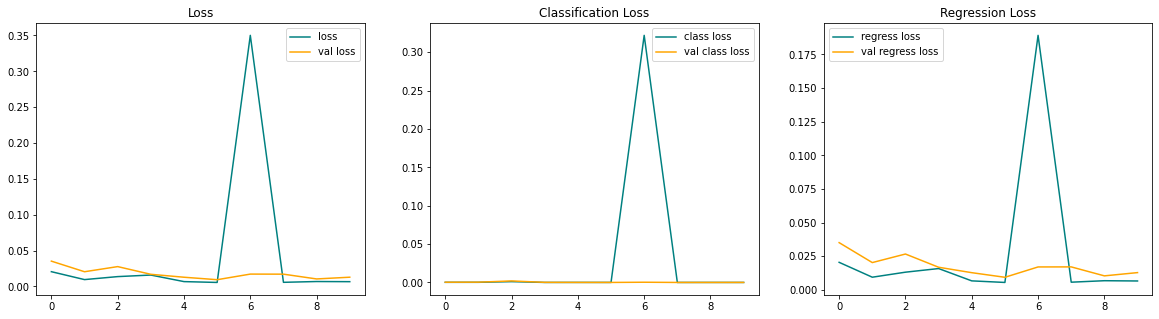

In [161]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['classification_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_val_classification_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['Regression_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_val_regression_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

#Testing

In [162]:
test_data = test.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


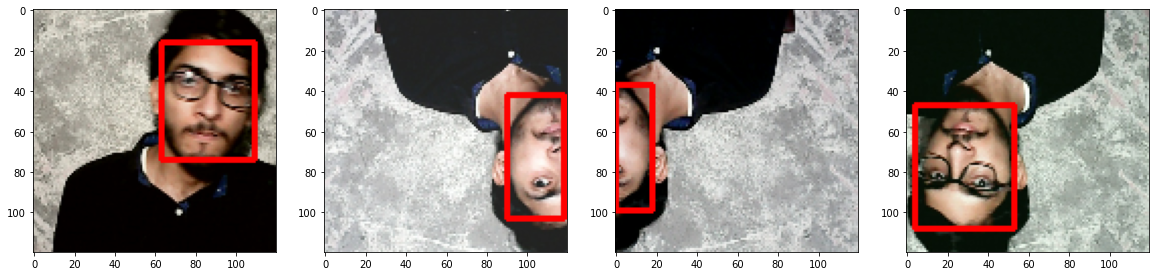

In [169]:
test_sample = test_data.next()
yhat = model.predict(test_sample[0])


fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Implemented By Muhamamd Hanan Asghar